## Stacks batch 4 - notebook 4, HWE filtering
<br>

The steps in this notebook are based on [this prior notebook]().



<br>
#### 10/25/2017

<Br>
### Convert matrix to genepop

My matrix currently has loci as column headers and individs as rows. I need individuals as columns going into the conversion script

In [1]:
cd ../scripts/PostStacksFilter_rSNP/

/mnt/hgfs/PCod-Compare-repo/scripts/PostStacksFilter_rSNP


In [3]:
!python transpose.py ../../stacks_b4_wgenome/batch_4_filteredMAF_filteredLoci50_filteredIndivids50.txt \
../../stacks_b4_wgenome/batch_4_filteredMAF_filteredLoci50_filteredIndivids50_transposed.txt

In [9]:
!python csv_conversion_forGENEPOP.py -h

usage: csv_conversion_forGENEPOP.py [-h] [-f INPUT] [-o OUTPUT] [-m POPMAP]
                                    [-pm PATH_POPMAP] [-ps PATH_STACKS]
                                    [-t TITLE] [-split SPLIT_BY]

convert matrix file (samples as column headers) to a genepop file.

optional arguments:
  -h, --help            show this help message and exit
  -f INPUT, --input INPUT
                        2 x 2 matrix file with samples as column headers, one
                        row per locus.
  -o OUTPUT, --output OUTPUT
                        output file in genepop format
  -m POPMAP, --popmap POPMAP
                        population map file
  -pm PATH_POPMAP, --path_popmap PATH_POPMAP
                        path to population map file
  -ps PATH_STACKS, --path_stacks PATH_STACKS
                        path to stacks files, including input file
  -t TITLE, --title TITLE
                        title for your genepop file
  -split SPLIT_BY, --split_by SPLIT_BY
                 

In [14]:
!python csv_conversion_forGENEPOP.py \
-f batch_4_filteredMAF_filteredLoci50_filteredIndivids50_transposed.txt \
-o batch_4_filteredMAF_filteredLoci50_filteredIndivids50_genepop.txt \
-m PopMap_combo_b4_filterIndivids.txt \
-pm ../ \
-ps ../../stacks_b4_wgenome \
-t "Korea + Alaska Data, stacks batch 4, filtered (w/o HWE filtering)" \
-s "space"

You have 17 populations.
These are your populations, with the number of samples in each:
OrderedDict([('Pohang15', 34), ('Geoje15', 37), ('Namhae15', 19), ('YellowSea16', 30), ('Jukbyeon07', 37), ('JinhaeBay07', 47), ('JinhaeBay08', 52), ('Boryeong07', 24), ('Geoje14', 35), ('Kodiak03', 46), ('Adak06', 32), ('WashCoast05', 44), ('HecStrait04', 45), ('SalishSea12_13', 40), ('JuandeFuca12', 22), ('PWSound12', 47), ('UnimakPass03', 45)])
creating script for part 2...
calling script for part 2...
transposing genotypes matrix...
writing loci into genepop file...
writing genotypes into genepop file by population...
done.


### Run genepop

`option 1 >> suboption 3`

In [16]:
cd ../../

/mnt/hgfs/PCod-Compare-repo


In [17]:
!mkdir analyses

In [18]:
cd analyses

/mnt/hgfs/PCod-Compare-repo/analyses


In [19]:
!mkdir genepop_HWE

In [20]:
cd genepop_HWE

/mnt/hgfs/PCod-Compare-repo/analyses/genepop_HWE


In [21]:
ls

batch_4_filteredMAF_filteredLoci50_filteredIndivids50_genepop.txt.P*


### Parse genepop

In [23]:
!python parse_genepop_HWEbylocus.py -h

usage: parse_genepop_HWEbylocus.py [-h] [-p P] [-op OUTPUTPVAL]
                                   [-of OUTPUTFIS]

optional arguments:
  -h, --help            show this help message and exit
  -p P, --P P           path & name of .P file output from genepop
  -op OUTPUTPVAL, --OUTPUTpval OUTPUTPVAL
                        path & name of the output file for the parsed HWE
                        pvalues
  -of OUTPUTFIS, --OUTPUTfis OUTPUTFIS
                        path & name of the output file for the parsed Fis
                        values


In [42]:
!python parse_genepop_HWEbylocus.py \
-p batch_4_filteredMAF_filteredLoci50_filteredIndivids50_genepop.txt.P \
-op batch_4_parsed_HWEpvals.txt \
-of batch_4_parsed_FISpvals.txt

generating dictionaries of pvalues and fis values...
writing output to files...
done.


In [46]:
infile = open("batch_4_parsed_HWEpvals.txt", "r")

percents = []
loci_list = []
na_count = 0

for line in infile:
    if "locus" not in line:
        if line.strip().split()[10] != "NA":
            new_percent = float(line.strip().split()[18])
            percents.append(new_percent)
            loci_list.append(line.strip().split()[0])
        else:
            na_count += 1

infile.close()

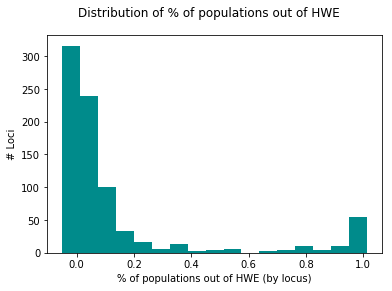

In [47]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(percents, bins = np.arange(-0.1, 1, .0625)+0.05, color = "darkcyan")
plt.suptitle("Distribution of % of populations out of HWE")
plt.xlabel("% of populations out of HWE (by locus)")
plt.ylabel("# Loci")
plt.show()

In [48]:
plt.close()

<br>

### Use multiple testing technique to generate chi-square value for each locus

In [50]:
from scipy.stats import chisqprob
import numpy as np

In [52]:
## STEP ONE: conduct chisquare and determine loci out of HWE. 
## write results to a file and save a list of the loci out of HWE. 

infile = open("batch_4_parsed_HWEpvals.txt", "r")
outfile = open("batch_4_parsed_HWEchisquare.txt", "w")

outfile.write("locus\tChiSquare\tdf\tpvalue\n")

sig_count = 0
loci_to_discard = []

for line in infile:
    if "locus" not in line:
        linelist= line.strip().split()
        outfile.write(linelist[0]) #write locus name to outfile
        sum = 0 #sum of ln(pvals)
        n_pops = 0 # number of pops with pvals (some will have NAs)
        for i in range(1,17):
            if linelist[i] != "NA" and float(linelist[i]) == 0.0:
                newval = np.log(float(0.00000000001))
                sum += newval
                n_pops += 1
            elif linelist[i] != "NA" and float(linelist[i]) != 0.0:
                newval = np.log(float(linelist[i]))
                sum += newval
                n_pops += 1
        chisquare = float(-2) * float(sum)
        df = n_pops * 2
        outfile.write("\t" + str(chisquare) + "\t" + str(df))
        pvalue = chisqprob(chisquare,df)
        if pvalue < 0.05:
            sig_count += 1
            loci_to_discard.append(linelist[0])
        outfile.write("\t" + str(pvalue) + "\n")
infile.close()
outfile.close()

print "You have ", sig_count, " loci out of HWE."

/home/mfisher5/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `chisqprob` is deprecated!
stats.chisqprob is deprecated in scipy 0.17.0; use stats.distributions.chi2.sf instead.


You have  344  loci out of HWE.


In [53]:
## STEP TWO: rewrite the file of HWEpvals by locus by population, 
## excluding those loci out of HWE. 

infile = open("batch_4_parsed_HWEpvals.txt", "r")
outfile = open("batch_4_HWEpvals_filtered.txt", "w")

locus_count = 0

for line in infile:
    if line.startswith("#"):
        outfile.write("# parsed GENEPOP output, HWE p-values by locus by population FILTERED #\n")
    elif line.startswith("locus"):
        outfile.write(line)
    else:
        locus = line.strip().split()[0]
        if locus not in loci_to_discard:
            outfile.write(line)
            locus_count += 1
infile.close()
outfile.close()
print locus_count, " loci written to output file."

2110  loci written to output file.


<br>
### filter file

In [54]:
pwd

u'/mnt/hgfs/PCod-Compare-repo/analyses/genepop_HWE'

In [55]:
cd ../../

/mnt/hgfs/PCod-Compare-repo


In [56]:
old = open("stacks_b4_wgenome/batch_4_filteredMAF_filteredLoci50_filteredIndivids50.txt", "r")
locifile = open("analyses/genepop_HWE/batch_4_HWEpvals_filtered.txt", "r")
new = open("stacks_b4_wgenome/batch_4_filteredMAF_filteredLoci50_filteredIndivids50_filteredHWE.txt", "w")
blacklisted = open("stacks_b4_wgenome/batch_4_filteredMAF_filteredLoci50_filteredIndivids50_filteredHWE_BAD.txt", "w")

## Note that my matrix file here has loci as column header, so I need to transpose it!
data_matrix = []
for line in old:
	tmp_line = ''
	tmp_line += line.strip()
	data_matrix.append(tmp_line.split(' '))
old.close()

transposed = zip(*data_matrix)

#write sample names to new file
new.write("\t".join(transposed[0]) + "\n")
blacklisted.write("\t".join(transposed[0]) + "\n")

#get list of loci that should be retained
loci_to_keep = []

for line in locifile: 
    if "locus" not in line:
        loci_to_keep.append(line.strip().split()[0]) 
locifile.close()

print "Preparing to copy ", len(loci_to_keep), " loci from old file"
print ""


cp_count = 0
rm_count = 0
loci_kept = []

for line in transposed[1:]: 
    locusID = line[0]
    if locusID in loci_to_keep:
        new.write("\t".join(line) + "\n")
        cp_count += 1
        loci_kept.append(locusID)
    else:
        blacklisted.write("\t".join(line) + "\n")
        rm_count += 1
new.close()
blacklisted.close()

print "Wrote ", cp_count, " loci to new matrix file."
print "Removed ", rm_count, " loci."

if len([i for i in loci_to_keep if i in loci_kept]) == len(loci_to_keep):
    print "All loci to keep were copied."
else:
    print "uhoh! not all loci to keep were copied."
    print "the following loci were not copied over:"
    print [i for i in loci_to_keep if i not in loci_kept]

Preparing to copy  2110  loci from old file

Wrote  2110  loci to new matrix file.
Removed  344  loci.
All loci to keep were copied.


<br>

### new distribution

In [57]:
cd analyses/genepop_HWE

/mnt/hgfs/PCod-Compare-repo/analyses/genepop_HWE


In [58]:
infile = open("batch_4_HWEpvals_filtered.txt", "r")

percents = []
loci_list = []

for line in infile:
    if "locus" not in line and "#" not in line:
        num = line.strip().split()[18]
        if num != "NA":
            new_percent = float(num)
            percents.append(new_percent)
            loci_list.append(line.strip().split()[0])

infile.close()

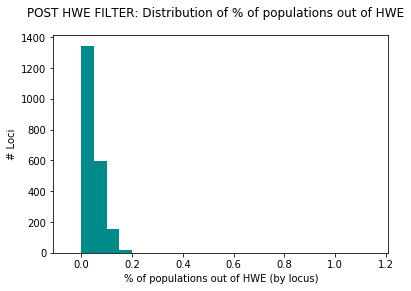

In [59]:
plt.hist(percents, bins = np.arange(-0.1, 1.1, .05)+0.05, color = "darkcyan")
plt.suptitle("POST HWE FILTER: Distribution of % of populations out of HWE")
plt.xlabel("% of populations out of HWE (by locus)")
plt.ylabel("# Loci")
plt.show()

In [60]:
plt.close()

<br>
<br>
### convert matrix to genepop file

In [61]:
pwd

u'/mnt/hgfs/PCod-Compare-repo/analyses/genepop_HWE'

In [62]:
cd ../../scripts/PostStacksFilter_rSNP/

/mnt/hgfs/PCod-Compare-repo/scripts/PostStacksFilter_rSNP


In [64]:
!python csv_conversion_forGENEPOP.py -h

usage: csv_conversion_forGENEPOP.py [-h] [-f INPUT] [-o OUTPUT] [-m POPMAP]
                                    [-pm PATH_POPMAP] [-ps PATH_STACKS]
                                    [-t TITLE] [-split SPLIT_BY]

convert matrix file (samples as column headers) to a genepop file.

optional arguments:
  -h, --help            show this help message and exit
  -f INPUT, --input INPUT
                        2 x 2 matrix file with samples as column headers, one
                        row per locus.
  -o OUTPUT, --output OUTPUT
                        output file in genepop format
  -m POPMAP, --popmap POPMAP
                        population map file
  -pm PATH_POPMAP, --path_popmap PATH_POPMAP
                        path to population map file
  -ps PATH_STACKS, --path_stacks PATH_STACKS
                        path to stacks files, including input file
  -t TITLE, --title TITLE
                        title for your genepop file
  -split SPLIT_BY, --split_by SPLIT_BY
                 

In [67]:
!python csv_conversion_forGENEPOP.py \
-f batch_4_filteredMAF_filteredLoci50_filteredIndivids50_filteredHWE.txt \
-o batch_4_filteredMAF_filteredLoci50_filteredIndivids50_filteredHWE_genepop.txt \
-m PopMap_combo_b4_filterIndivids.txt \
-pm ../ \
-ps ../../stacks_b4_wgenome \
-t "Korea + Alaska Data Final Genepop, stacks batch 4, filtered (MAF / Loci / Individs / HWE)" \
-s "tab"

You have 17 populations.
These are your populations, with the number of samples in each:
OrderedDict([('Pohang15', 34), ('Geoje15', 37), ('Namhae15', 19), ('YellowSea16', 30), ('Jukbyeon07', 37), ('JinhaeBay07', 47), ('JinhaeBay08', 52), ('Boryeong07', 24), ('Geoje14', 35), ('Kodiak03', 46), ('Adak06', 32), ('WashCoast05', 44), ('HecStrait04', 45), ('SalishSea12_13', 40), ('JuandeFuca12', 22), ('PWSound12', 47), ('UnimakPass03', 45)])
creating script for part 2...
calling script for part 2...
transposing genotypes matrix...
writing loci into genepop file...
writing genotypes into genepop file by population...
done.


<br>

### FINAL GENEPOP FILE:
### batch_4_filteredMAF_filteredLoci50_filteredIndivids50_filteredHWE_genepop.txt
#### 2110  loci
